In [224]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel

pd.set_option('display.float_format', lambda x: '%8.2f' % x)

# Reading the data with ; as separator
tr = pd.read_csv('Training.csv', delimiter = ";", decimal = ",")
vd = pd.read_csv('Validation.csv', delimiter = ";", decimal = ",")
tot = pd.DataFrame(np.concatenate((tr,vd)))
tot.columns = ['v1','v2','v3','v4','v5','v6','v7','v8','v9','v10','v11','v12','v13','v14','v15','v16','v17','v18','v19','v20','v21','classlabel']

# Checking how many NA values exist
tot.isnull().sum()

v1              69
v2               0
v3              42
v4               0
v5               0
v6              42
v7               0
v8             103
v9               0
v10              0
v11             66
v12              0
v13              0
v14             69
v15           2256
v16            103
v17              0
v18             66
v19              0
v20              0
v21              0
classlabel       0
dtype: int64

In [225]:
#Removing v15 for having 60% missing data
tot = tot.drop('v15', 1)

#Obtaining train and test sets with no NAs
tot = tot.dropna()
tot = tot.reset_index(drop=True)

#Variable description
summary = tot.describe()
summary.transpose()


,count,unique,top,freq
v1,3713,9,v,2046
v2,3713,3,g,3493
v3,3713.00,340.00,23.25,65.00
v4,3713,2,t,3363
v5,3713.00,131.00,0.00,210.00
v6,3713,2,b,2430
v7,3713,2,t,2252
v8,3713.00,164.00,0.00,968.00
v9,3713.00,213.00,0.00,123.00
v10,3713,23,0,1461


In [226]:
# Frequency tables for each categorical variable
feat = tot[['v1', 'v2', 'v4','v6','v7','v11','v13','v14','v18','v19','v20','v21']]
for column in feat.columns:     #feat.select_dtypes(include=['object']).columns  for dataframe with more variable types
    display(pd.crosstab(index = feat[column], columns='% observations', normalize='columns'))


col_0,% observations
v1,
bb,0.09
dd,0.01
ff,0.04
h,0.27
j,0.01
n,0.01
o,0.00
v,0.55
z,0.01


col_0,% observations
v2,
g,0.94
p,0.00
s,0.05


col_0,% observations
v4,
f,0.09
t,0.91


col_0,% observations
v6,
a,0.35
b,0.65


col_0,% observations
v7,
f,0.39
t,0.61


col_0,% observations
v11,
l,0.01
u,0.83
y,0.16


col_0,% observations
v13,
f,0.50
t,0.50


col_0,% observations
v14,
W,0.10
aa,0.06
c,0.21
cc,0.10
d,0.03
e,0.04
ff,0.04
i,0.06
j,0.01


col_0,% observations
v18,
g,0.83
gg,0.01
p,0.16


col_0,% observations
v19,
0,0.50
1,0.50


col_0,% observations
v20,
f,0.57
t,0.43


col_0,% observations
v21,
f,0.57
t,0.43


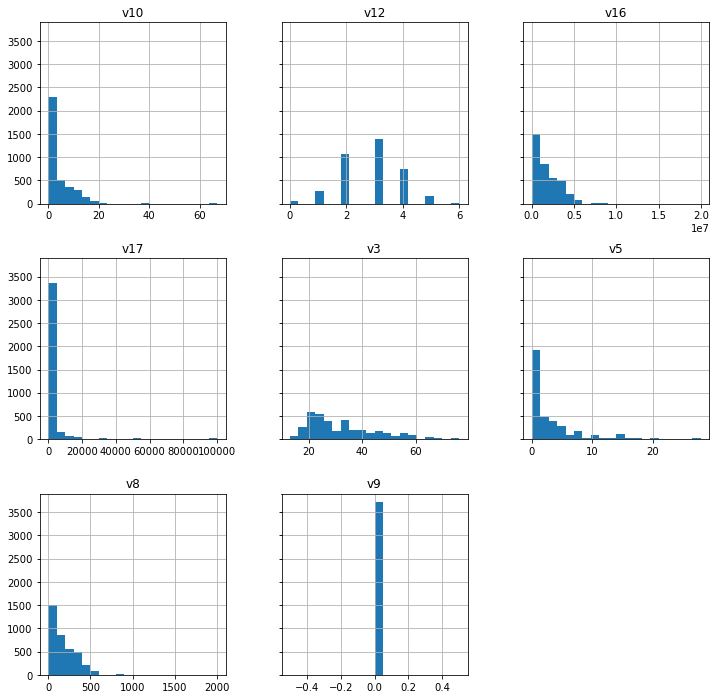

In [227]:
# Histograms for each numeric variable
num = tot[['v3','v5','v8','v9','v10','v12','v16','v17']]
num = num.astype(int)
num.hist(bins=20, sharey=True, figsize=(12, 12))
plt.show()

In [228]:
# Value count for the class label (Y variable)
tot['classlabel'].value_counts()

yes.    3356
no.      357
Name: classlabel, dtype: int64

In [229]:
#Encoding the classlabel
total = tot
class_mapping = {label:idx for idx,label in enumerate(np.unique(tot['classlabel']))}
total['classlabel'] = tot['classlabel'].map(class_mapping)
total['classlabel'].value_counts()

1    3356
0     357
Name: classlabel, dtype: int64

In [215]:
#Export cleaned database to spreadsheet
#total.to_csv('kreditech.csv')

In [230]:
#Creating dummies for non-numerical variables using function pd.get_dummies()
feat = pd.get_dummies(feat)
Y = total[['classlabel']]
X = pd.concat([num.reset_index(drop=True), feat], axis=1)
#Drop v16 for being the same as v8
X = X.drop('v16', 1)
#Drop v9 for having no data variation
X = X.drop('v9', 1)
X.describe()

,v3,v5,v8,v10,v12,v17,v1_bb,v1_dd,v1_ff,v1_h,...,v14_x,v18_g,v18_gg,v18_p,v19_0,v19_1,v20_f,v20_t,v21_f,v21_t
count,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,...,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00,3713.00
mean,32.40,3.11,164.08,4.22,2.83,2139.10,0.09,0.01,0.04,0.27,...,0.09,0.83,0.01,0.16,0.50,0.50,0.57,0.43,0.57,0.43
std,12.48,4.36,158.78,6.77,1.04,8548.36,0.29,0.08,0.20,0.44,...,0.28,0.37,0.09,0.36,0.50,0.50,0.50,0.50,0.49,0.49
min,13.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,22.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,28.00,1.00,120.00,2.00,3.00,108.00,0.00,0.00,0.00,0.00,...,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00
75%,40.00,5.00,280.00,6.00,3.00,1000.00,0.00,0.00,0.00,1.00,...,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
max,76.00,28.00,2000.00,67.00,6.00,100000.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [231]:
#Partition the dataset into training and validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
y_train = pd.Series(y_train['classlabel'])
y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1114 entries, 3545 to 1666
Data columns (total 1 columns):
classlabel    1114 non-null int64
dtypes: int64(1)
memory usage: 17.4 KB


In [232]:
#Predictive modelling using xGboost ML algorithm

#Fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [233]:
#Predictions on validation data set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.58%


In [234]:
#Comparing the actual vs predicted results
results = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(y_pred)], axis=1)
results.columns = ['Y_validation',"Y_predicted"]
#results

#Confusion matrix TN FP / FN TP
m_confusion = confusion_matrix(y_test, y_pred)
m_confusion

array([[  87,   20],
       [   7, 1000]])

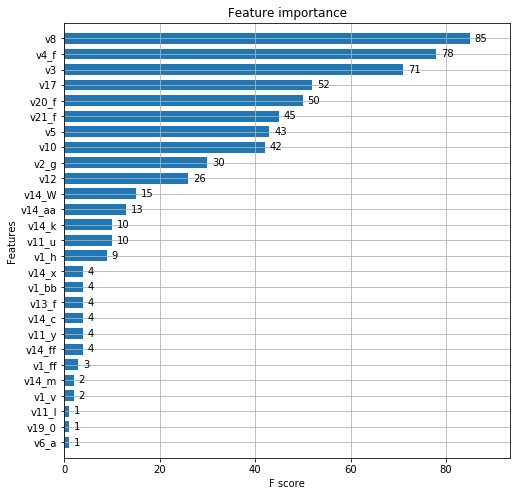

In [235]:
#Plotting variable importance
fig, ax = plt.subplots(figsize=(8, 8))
plot_importance(model, ax=ax, height=0.7)
#plt.gca().invert_xaxis()
plt.show()

#Plotting specific trees from the model
#plot_tree(model)
#fig = plt.gcf()
#fig.set_size_inches(15, 10)
#plt.show()

In [236]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.000, n=52, Accuracy: 97.58%
Thresh=0.002, n=27, Accuracy: 97.58%
Thresh=0.002, n=27, Accuracy: 97.58%
T